In [1]:
import tensorflow as tf

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
tf.__version__

'2.1.0'

In [5]:
from IPython import display
# import PIL
import os
import time
import glob
import matplotlib.pyplot as plt
BUFFER_SIZE = 80000
BATCH_SIZE = 256

In [7]:
def to_its_ds(root, cache=False):
    list_ds = tf.data.Dataset.list_files(root)
    image_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    image_ds = prepare_for_training(image_ds, cache=cache, shuffle_buffer_size=BUFFER_SIZE)
    return image_ds

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img) # input tensor is numpy array
    return img

def decode_img(img):
    img = tf.io.decode_png(img, channels=3)
#     img = tf.dtypes.as_dtype(tf.float32)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img - 0.5) / 0.5 # Normalize the images to [-1, 1]
    img = tf.image.resize(img, [96, 96])
    return img

# For well shuffled, batched which gonna to be available
def prepare_for_training(ds, cache=True, shuffle_buffer_size=200000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=BUFFER_SIZE)
    # Repeat forever
#     ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
degree_0_dir = "/tf/robertnb/p3-prewave-aoi-saiap/Alu-M2-08231119/OK/0/*.png"
degree_0_ds = to_its_ds(degree_0_dir)

In [16]:
next(iter(degree_0_ds)).numpy()

array([[[[-0.8980392 , -0.84313726, -0.92941177],
         [-0.85061276, -0.7957108 , -0.8977941 ],
         [-0.74215686, -0.6979166 , -0.82549024],
         ...,
         [-0.923652  , -0.8723039 , -0.94007355],
         [-0.8955882 , -0.8355392 , -0.91654414],
         [-0.8745098 , -0.8039216 , -0.8901961 ]],

        [[-0.8980392 , -0.84926474, -0.94779414],
         [-0.85472965, -0.810072  , -0.9161765 ],
         [-0.76494336, -0.7301816 , -0.85497856],
         ...,
         [-0.92700297, -0.8756549 , -0.9367226 ],
         [-0.8997051 , -0.8396561 , -0.91041666],
         [-0.8745098 , -0.8039216 , -0.8840686 ]],

        [[-0.8731209 , -0.83104575, -0.9230392 ],
         [-0.83766085, -0.7908101 , -0.89476997],
         [-0.76766366, -0.7255885 , -0.84283346],
         ...,
         [-0.9356503 , -0.89154416, -0.9434934 ],
         [-0.90264887, -0.8492188 , -0.91212726],
         [-0.8595588 , -0.7989379 , -0.8723856 ]],

        ...,

        [[-0.92156863, -0.8638072 , -0

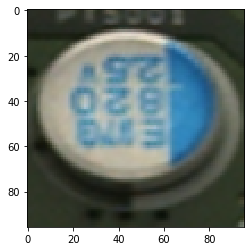

In [18]:
x = next(iter(degree_0_ds)).numpy() * 0.5 + 0.5
plt.figure()
plt.imshow(x[0])

In [19]:
layers = tf.keras.layers
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(12*12*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((12, 12, 256)))
    assert model.output_shape == (None, 12, 12, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 96, 96, 3)

    return model

In [20]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [23]:
generated_image[0, :, :, :]

<tf.Tensor: shape=(96, 96, 3), dtype=float32, numpy=
array([[[-1.61104367e-06,  4.03775521e-05, -1.24141297e-04],
        [ 2.55194871e-04, -4.94407199e-04,  5.61132154e-04],
        [-7.50331674e-06, -6.44333068e-06,  2.57461303e-04],
        ...,
        [-2.37739156e-03, -2.81891844e-05,  8.62197485e-04],
        [ 5.82475099e-04,  3.35705932e-04, -1.30191082e-04],
        [ 9.52996634e-05, -1.24606211e-03, -3.55399417e-04]],

       [[ 1.67131861e-04, -3.09205701e-04,  7.50114152e-04],
        [-1.71060034e-03,  6.66735112e-04, -1.40274887e-03],
        [-2.98884086e-04,  1.28954111e-04,  2.16984481e-05],
        ...,
        [-1.59102352e-03, -1.17971550e-03, -2.64505506e-03],
        [ 1.08019495e-03,  4.97690577e-04, -2.63246987e-03],
        [ 9.53321171e-04, -2.62316922e-03, -1.27128582e-03]],

       [[-2.09483434e-04,  3.42394458e-04, -1.40674078e-04],
        [-3.38756945e-06,  6.09265408e-04, -4.86898207e-04],
        [-7.84932752e-04,  3.31886840e-04,  9.16090794e-05],
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


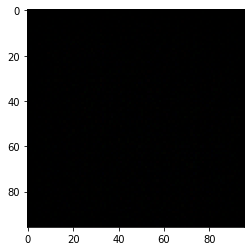

In [22]:
plt.imshow(generated_image[0, :, :, :])

In [24]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[96, 96, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [25]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00136578]], shape=(1, 1), dtype=float32)


# Define the loss and optimizers

In [26]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
# real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [28]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# CheckPoints - helpful in case a long running training task is interrupted. 

In [31]:
checkpoint_dir = '/tf/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Define the training loop

In [32]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [33]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [34]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
      plt.axis('off')

  plt.savefig('/tf/robertnb/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [35]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# TRAIN

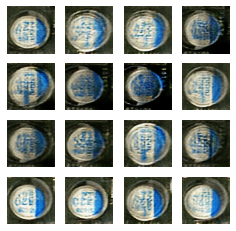

In [36]:
train(degree_0_ds, EPOCHS)

# Restore CheckPoints

In [37]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [39]:
predictions = generator(seed, training=False)
predictions
#   fig = plt.figure(figsize=(4,4))

#   for i in range(predictions.shape[0]):
#       plt.subplot(4, 4, i+1)
#       plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
#       plt.axis('off')

<tf.Tensor: shape=(16, 96, 96, 3), dtype=float32, numpy=
array([[[[-0.53460556, -0.5044894 , -0.5806381 ],
         [-0.64344394, -0.564259  , -0.6268725 ],
         [-0.7038529 , -0.6091543 , -0.7116569 ],
         ...,
         [-0.7760157 , -0.711427  , -0.8177697 ],
         [-0.7973349 , -0.68952215, -0.7721234 ],
         [-0.7022891 , -0.58345294, -0.67807364]],

        [[-0.6724405 , -0.5587019 , -0.6812798 ],
         [-0.6660475 , -0.610595  , -0.7270235 ],
         [-0.7201923 , -0.61905766, -0.74597764],
         ...,
         [-0.7955178 , -0.73359394, -0.8666234 ],
         [-0.85215485, -0.7730636 , -0.8328147 ],
         [-0.7826319 , -0.6483133 , -0.81980056]],

        [[-0.669173  , -0.6009496 , -0.6946052 ],
         [-0.699533  , -0.62384856, -0.7142414 ],
         [-0.70826906, -0.59664965, -0.6958017 ],
         ...,
         [-0.8776219 , -0.79784846, -0.8601813 ],
         [-0.89761096, -0.83041704, -0.8874928 ],
         [-0.8413292 , -0.75173616, -0.8469684 

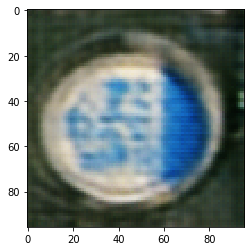

In [41]:
plt.figure()
plt.imshow(predictions[0, :, :, :] * 0.5 + 0.5)

In [46]:
def convert_and_save(image, filename):
    img = tf.image.convert_image_dtype(image, tf.uint8)
#     img = tf.image.convert_image_dtype(predictions[0, :, :, :] * 0.5 + 0.5, tf.uint8)
    encoded_img = tf.image.encode_png(img)
    tf.io.write_file(
                        filename= filename,
                        contents= encoded_img,
                        name=None
                    )

# Continue training from last checkpoints

In [54]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 10
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def train_and_save_image(dataset, epochs):
  for epoch in range(epochs):
    if not os.path.exists('/tf/dcgan_generator_img/E'+str(epoch+1)):
            os.makedirs('/tf/dcgan_generator_img/E'+str(epoch+1))
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    predictions = generator(seed, training=False)
    for i in range(predictions.shape[0]):
        convert_and_save(predictions[i, :, :, :] * 0.5 + 0.5, '/tf/dcgan_generator_img/E'+str((epoch+1))+'/'+str(i)+'.png')

    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  predictions = generator(seed, training=False)
  for i in range(predictions.shape[0]):
        convert_and_save(predictions[i, :, :, :] * 0.5 + 0.5, '/tf/dcgan_generator_img/E'+str(epochs)+'/'+str(i)+'.png')


In [ ]:
train_and_save_image(degree_0_ds, EPOCHS)

Time for epoch 520 is 20.631237506866455 sec
